In [1]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection as sk_model_selection

import tensorflow
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

import numpy as np
import pandas as pd
from gwpy.plot import Plot
from gwpy.timeseries import TimeSeries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('g2net-gravitational-wave-detection/training_labels.csv')

sample_submission = pd.read_csv('g2net-gravitational-wave-detection/sample_submission.csv')
test=sample_submission
def get_train_file_path(image_id):
    return "g2net-gravitational-wave-detection/train/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

def get_test_file_path(image_id):
    return "g2net-gravitational-wave-detection/test/{}/{}/{}/{}.npy".format(
        image_id[0], image_id[1], image_id[2], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

In [4]:
train_1 = train[train['target']==1]
train_0 = train[train['target']==0]
final_train = pd.concat([train_1[0:35000], train_0[0:35000]], axis=0)
final_train 

,id,target,file_path
0,00000e74ad,1,g2net-gravitational-wave-detection/train/0/0/0...
4,0000a38978,1,g2net-gravitational-wave-detection/train/0/0/0...
5,0000bb9f3e,1,g2net-gravitational-wave-detection/train/0/0/0...
7,0000d61b7b,1,g2net-gravitational-wave-detection/train/0/0/0...
8,0001016d12,1,g2net-gravitational-wave-detection/train/0/0/0...
...,...,...,...
69770,1fb0eeb07a,0,g2net-gravitational-wave-detection/train/1/f/b...
69771,1fb10df644,0,g2net-gravitational-wave-detection/train/1/f/b...
69775,1fb2076daa,0,g2net-gravitational-wave-detection/train/1/f/b...
69776,1fb20e7421,0,g2net-gravitational-wave-detection/train/1/f/b...


In [5]:
df_train, df_valid = sk_model_selection.train_test_split(final_train, test_size=0.01, random_state=42, stratify=final_train["target"],)
print("df_train:",len(df_train))
print("df_valid:",len(df_valid))

df_train: 69300
df_valid: 700


In [6]:
df_train

,id,target,file_path
63705,1cf2e5fbe1,0,g2net-gravitational-wave-detection/train/1/c/f...
4515,0200e9249e,1,g2net-gravitational-wave-detection/train/0/2/0...
12401,05a2b2d6b7,1,g2net-gravitational-wave-detection/train/0/5/a...
16255,0760e551b8,1,g2net-gravitational-wave-detection/train/0/7/6...
11637,05453e19d3,1,g2net-gravitational-wave-detection/train/0/5/4...
...,...,...,...
15719,07260ab1c6,0,g2net-gravitational-wave-detection/train/0/7/2...
21383,09b6eac0e4,0,g2net-gravitational-wave-detection/train/0/9/b...
25410,0b93a65f84,0,g2net-gravitational-wave-detection/train/0/b/9...
10171,049b68f026,1,g2net-gravitational-wave-detection/train/0/4/9...


In [7]:
from scipy.signal import butter, filtfilt
import torch
from torch.fft import fft, ifft

def tukey(M, alpha=0.15, needs_trunc=False):
    n = np.arange(0, M)
    width = int(np.floor(alpha*(M-1)/2.0))
    
    n1 = n[0:width+1]
    n2 = n[width+1:M-width-1]
    n3 = n[M-width-1:]

    w1 = 0.5 * (1 + np.cos(np.pi * (-1 + 2.0*n1/alpha/(M-1))))
    w2 = np.ones(n2.shape)
    w3 = 0.5 * (1 + np.cos(np.pi * (-2.0/alpha + 1 + 2.0*n3/alpha/(M-1))))

    w = np.concatenate((w1, w2, w3))

    return w

window = tukey(4096,alpha=0.15)

def whiten(signal):
    tukey_win = tukey(4096,0.15)
    ft = fft(torch.from_numpy(signal).float()* window)
    mag = torch.sqrt(torch.real(ft*torch.conj(ft))) 
    inv = torch.real(ifft(ft/mag)).numpy() * np.sqrt(len(signal)/2)
    return inv

def bandpass(signal, sampling_rate=2048, lower_end=30, upper_end=350):
    nyquist_frequency = sampling_rate/2.0
    bb, ab = butter(4, [lower_end/nyquist_frequency, upper_end/nyquist_frequency], btype='band')
    return filtfilt(bb, ab, signal)

In [8]:
def test_pipeline_alt(f_name):
    data = np.load(f_name)
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
#     return TimeSeries(whiten(d1), sample_rate=2048),TimeSeries(whiten(d2), sample_rate=2048),TimeSeries(whiten(d3), sample_rate=2048)
    return TimeSeries(bandpass(whiten(d1)), sample_rate=2048),TimeSeries(bandpass(whiten(d2)), sample_rate=2048),TimeSeries(bandpass(whiten(d3)), sample_rate=2048)

def final_pipeline(f_name,qrange=(14,21),frange=(25,300)):
    image=[]
    p1, p2, p3 = test_pipeline_alt(f_name=f_name)
    p1_qed = p1.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    p2_qed = p2.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    p3_qed = p3.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    
    image.append(p1_qed)
    image.append(p2_qed)
    image.append(p3_qed)
    
    image1= (image[0] - np.mean(image[0])) / np.std(image[0])
    image2= (image[1] - np.mean(image[1])) / np.std(image[1])
    image3= (image[2] - np.mean(image[2])) / np.std(image[2])
    img1= np.multiply(image1,image2)
    img=np.multiply(img1,image3)
    
    return img

In [9]:
def Cleaned_signal(signal):
    signal = np.load(signal)
    d1 = TimeSeries(signal[0,:], sample_rate=2048)
    d2 = TimeSeries(signal[1,:], sample_rate=2048)
    d3 = TimeSeries(signal[2,:], sample_rate=2048)
#     return TimeSeries(whiten(d1), sample_rate=2048),TimeSeries(whiten(d2), sample_rate=2048),TimeSeries(whiten(d3), sample_rate=2048)
    return TimeSeries(bandpass(whiten(d1)), sample_rate=2048),TimeSeries(bandpass(whiten(d2)), sample_rate=2048),TimeSeries(bandpass(whiten(d3)), sample_rate=2048)

def Pipeline(f_name,qrange=(14,21),frange=(25,300)):
    image=[]
    p1, p2, p3 = test_pipeline_alt(f_name=f_name)
    p1_qed = p1.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    p2_qed = p2.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    p3_qed = p3.q_transform(qrange=qrange, frange=frange, logf=True, whiten=False, fres=2048)
    
    image.append(p1_qed)
    image.append(p2_qed)
    image.append(p3_qed)

#     image1= (image[0] - np.mean(image[0])) / np.std(image[0])
#     image2= (image[1] - np.mean(image[1])) / np.std(image[1])
#     image3= (image[2] - np.mean(image[2])) / np.std(image[2])
#     img1= np.multiply(image1,image2)
#     img=np.multiply(img1,image3)

    img1= np.multiply(image[0],image[1])
    img=np.multiply(img1,image[2])
    
    return img

In [10]:
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=32,shuffle=True):
        self.idx = df["id"].values
        self.paths = df["file_path"].values
        self.y =  df["target"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
    
    
    def __getitem__(self,ids):
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        list_x = np.array([Pipeline(x) for x in batch_paths])
        batch_X = np.stack(list_x)
        
        if self.is_train:
            return batch_X, batch_y
        else:
            return batch_X


In [11]:
train_dataset = Dataset(df_train,is_train=True)
valid_dataset = Dataset(df_valid,is_train=True)
test_dataset = Dataset(sample_submission,is_train=False)

Target: 0 Shape (1000, 2048)


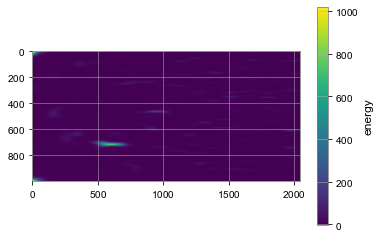

Target: 1 Shape (1000, 2048)


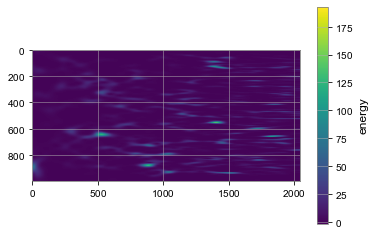

Target: 1 Shape (1000, 2048)


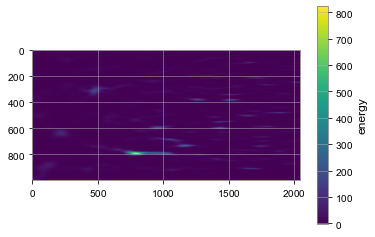

Target: 0 Shape (1000, 2048)


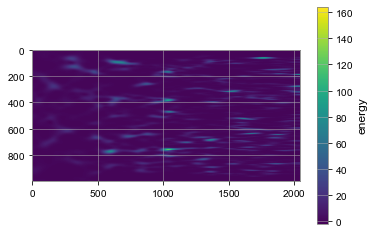

Target: 1 Shape (1000, 2048)


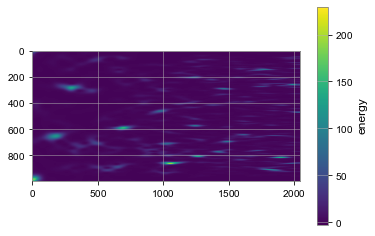

Target: 0 Shape (1000, 2048)


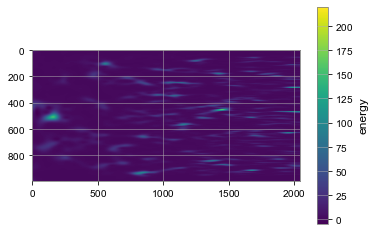

Target: 0 Shape (1000, 2048)


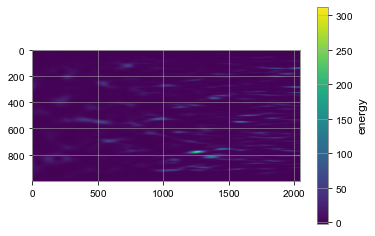

Target: 0 Shape (1000, 2048)


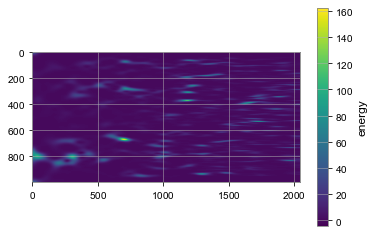

Target: 0 Shape (1000, 2048)


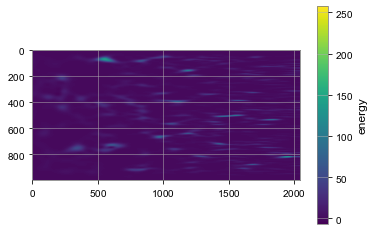

Target: 0 Shape (1000, 2048)


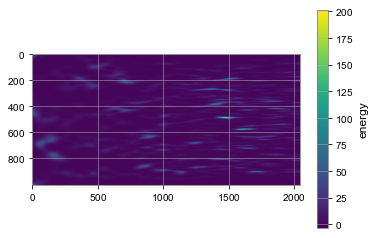

In [12]:
for i in range(10,20):
    image, label = train_dataset[i] 
    plt.imshow(image[0])
    print('Target:', label[i],'Shape', image[0].shape)
    plt.colorbar(label="energy")
    plt.show() 

In [13]:
train_dataset[0]

(array([[[ 1.58719053e+01,  1.58719053e+01,  1.58719053e+01,
          ...,  5.78065589e-03,  5.78065589e-03,
           5.78065589e-03],
         [ 1.67424202e+01,  1.67424202e+01,  1.67424202e+01,
          ...,  1.11857755e-02,  1.11857755e-02,
           1.11857755e-02],
         [ 1.77599678e+01,  1.77599678e+01,  1.77599678e+01,
          ...,  1.82157084e-02,  1.82157084e-02,
           1.82157084e-02],
         ...,
         [ 1.42598753e+01,  1.42598753e+01,  1.42598753e+01,
          ...,  4.46965732e-03,  4.46965732e-03,
           4.46965732e-03],
         [ 1.48711500e+01,  1.48711500e+01,  1.48711500e+01,
          ...,  7.87020475e-03,  7.87020475e-03,
           7.87020475e-03],
         [ 1.57439156e+01,  1.57439156e+01,  1.57439156e+01,
          ..., -5.93457511e-03, -5.93457511e-03,
          -5.93457511e-03]],
 
        [[ 1.67951763e-01,  1.67951763e-01,  1.67951763e-01,
          ...,  9.81279463e-02,  9.81279463e-02,
           9.81279463e-02],
         [ 2.0654